In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
import warnings
import json
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [2]:
def sin_func(x, A, P_pi, phi):
    return A * np.sin(np.pi * x / P_pi + phi) + A

In [3]:
root_path = Path('/Users/jiahaozhan/Google Drive/Other Computers/CM300/Dione_wafer3_BO')
data_path = root_path / 'pdk_thermphase_test_cells'

no = 0
data_dir_gen = sorted(data_path.glob(f'reticle27/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    # print(df.columns)
    # print(df['wavelength'])
    # ret = int(df['reticle'][0])
    
    wavel = df['wavelength'][no]
    trans = df['transmission_ch1'][no]
    volts = df['smu_voltage'][no]
    currs = df['smu_current'][no]

currs = [i - currs[0] for i in currs] # current should be 0 at 0 V
currs_mA = np.multiply(currs, 1000)

elec_pwrs = np.multiply(volts, currs_mA)
res = np.divide(volts[1:], currs[1:])

print(volts)
print(currs_mA)
print(res)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
[ 0.         3.3686129  6.6816479 10.0338529 13.1065349 16.1177149
 18.9996649 21.7279849 24.3848649 26.7950249 29.0504849 31.1634749
 33.1287249 35.0170849 36.7132049 38.2928849 39.7563349 41.1154649
 42.3817249 43.5897849 44.6491449 45.5970849 46.1244649 36.7135749
 34.0966849 32.7184249]
[29.68580925 29.93273561 29.89878395 30.51912676 31.02176724 31.57950433
 32.21651723 32.80723528 33.58832482 34.42283333 35.29773247 36.2223419
 37.12473507 38.13341831 39.17176791 40.24515851 41.34697258 42.47113595
 43.58819399 44.793691   46.0555758  47.6970303  62.64712729 70.38807459
 76.40954623]


[0.014356973031246462, 10, 0.11093654947414647]
[ 0.01458655 11.71255992  0.04268564]


Text(0, 0.5, 'Heater resistance (ohm)')

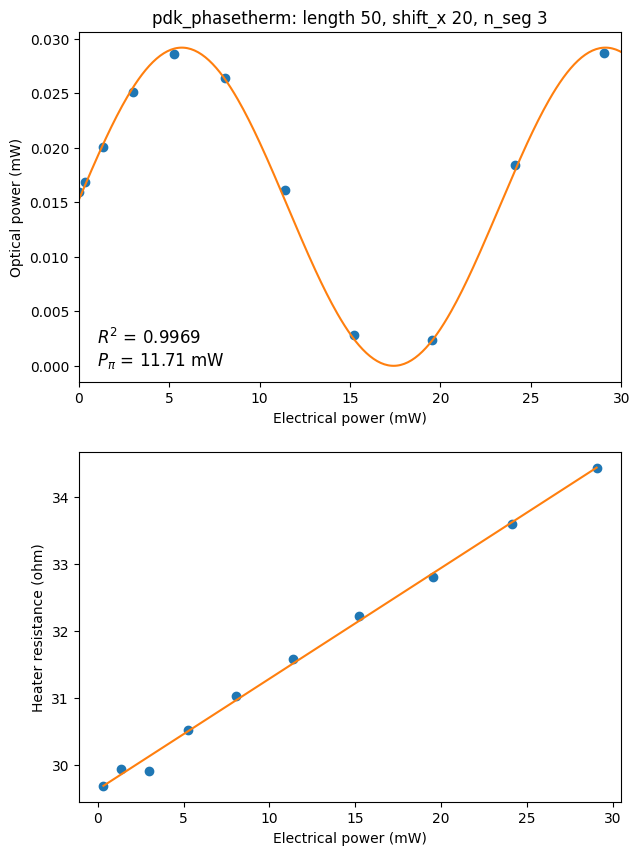

In [13]:
# fit the transmission data at 1310 nm with a sinusoidal function
trans_1310 = [tr[1000] for tr in trans]
trans_1310_mW = 10**np.divide(trans_1310, 10)

x_data, y_data = elec_pwrs[:11], trans_1310_mW[:11]
x_data_new = np.arange(0, 50, 0.1)

# Guess the initial parameters
A_init = max(y_data)/2
P_init = 2*(abs(x_data[np.where(y_data == max(y_data))][0] - x_data[np.where(y_data == min(y_data))][0]))
phi_init = np.arcsin(y_data[0]/A_init - 1)
p_init = [A_init, 10, phi_init]
print(p_init)

p_opt, p_cov = curve_fit(sin_func, x_data, y_data, p0=p_init)
print(p_opt)

y_predicted = sin_func(x_data, *p_opt)
residuals = y_data - y_predicted
ss_total = np.sum((y_data - np.mean(y_data))**2)
ss_residual = np.sum(residuals**2)
r_squared = 1 - (ss_residual / ss_total)

title = f"pdk_phasetherm: length {df['length'][no]}, shift_x {df['shift_x'][no]}, n_seg {df['n_seg'][no]}"
fig, axes = plt.subplots(2, 1, figsize=(7, 10))
ax = axes[0]
ax.plot(x_data, y_data, 'o')
# ax.plot(elec_pwrs, trans_1310_mW, 'o')
ax.plot(x_data_new, sin_func(x_data_new, *p_opt))
ax.set_xlabel('Electrical power (mW)')
ax.set_ylabel('Optical power (mW)')
ax.set_title(title)
ax.set_xlim([0, 30])
ax.text(1, 0, f'$R^{2}$ = {r_squared:.4f}' + '\n' + '$P_{\pi}$ = ' + f'{p_opt[1]:.2f} mW', fontsize=12)

ax = axes[1]
ep_data, res_data = elec_pwrs[1:11], res[:10]
coefs = poly.polyfit(ep_data, res_data, 1)
ffit = poly.Polynomial(coefs) 
ax.plot(ep_data, res_data, 'o')
ax.plot(ep_data, ffit(ep_data))
ax.set_xlabel('Electrical power (mW)')
ax.set_ylabel('Heater resistance (ohm)')

In [ ]:
|